# Exercise 1: Optical flow

## Advanced Computer Vision Methods 2023/2024

In this exercise you will implement two of the most well known optical flow estimation methods, the Lucas-Kanade method and the Horn-Schunck method. Note that there
are two Python functions attached to the material for the exercise that you can use:
gausssmooth performs Gaussian smoothing of an image and gaussderiv computes first
and second Gaussian derivatives of an image.

In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

from material.ex1_utils import gaussderiv, gausssmooth, hsv_to_rgb, show_flow, rotate_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
def read_folder_to_video(folder:str):
  frames = []
  for img in os.listdir(folder):
    if((not "png" in img ) and ( not "jpg" in img)):
      raise Exception(f"NOT AN IMAGE {img}")
    
    img = cv2.imread(os.path.join(folder, img), cv2.IMREAD_GRAYSCALE)
    frames.append(img)
  
  return np.array(frames)


In [72]:
def get_frame_derivatives(frame_1: np.ndarray, frame_2: np.ndarray, sigma:int = 1):
  # Temporal derivative
  sigma = 1
  i_t = gausssmooth(frame_2 - frame_1, sigma)

  # Spatial derivative
  i_x1, i_y1 = gaussderiv(frame_1, sigma)
  i_x2, i_y2 = gaussderiv(frame_2, sigma)
  i_x = (i_x1 + i_x2) / 2
  i_y = (i_y1 + i_y2) / 2

  return  i_x, i_y, i_t

In [73]:
from typing import Tuple

def lucas_kanade(frame_1: np.ndarray, frame_2: np.ndarray, N: int = 3) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute optical flow using Lucas-Kanade method.

    Parameters:
        frame_1 (np.ndarray): First frame (grayscale).
        frame_2 (np.ndarray): Second frame (grayscale), shifted in time with respect to the first frame.
        N (int): Size of the window for spatial averaging. Default is 3.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple containing the horizontal (U) and vertical (V) components of the optical flow.
    """
    
    i_x, i_y, i_t = get_frame_derivatives(frame_1, frame_2)

    # Optical flow vectors
    kernel = np.ones((N, N))
    i_x_i_t = cv2.filter2D((i_x * i_t), -1, kernel)
    i_y_i_t = cv2.filter2D((i_y * i_t), -1, kernel)
    i_x2 = cv2.filter2D(np.square(i_x), -1, kernel)
    i_y2 = cv2.filter2D(np.square(i_y), -1, kernel)
    i_x_i_y = cv2.filter2D((i_x * i_y), -1, kernel)

    denominator = (i_x2 * i_y2 - i_x_i_y * i_x_i_y)  # we have the same denominator on both u and v
    zero_mask = denominator == 0 # gives a mask of all cells with value 0
    denominator[zero_mask] = 10e-5  # numerical stability - no division by zero
    U = (- i_y2 * i_x_i_t + i_x_i_y * i_y_i_t) / denominator
    V = (i_x_i_y * i_x_i_t - i_x2 * i_y_i_t) / denominator

    return U, V

In [196]:
def horn_schunck(frame_1: np.ndarray, frame_2: np.ndarray, n_iters: int = 1000, lmbd: float = 0.5, start_uv:Tuple[np.ndarray, np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute optical flow using Horn-Schunck method.

    Parameters:
        frame_1 (np.ndarray): First frame (grayscale).
        frame_2 (np.ndarray): Second frame (grayscale), shifted in time with respect to the first frame.
        n_iters (int): Number of iterations for optimization. Default is 1000.
        lmbd (float): Regularization parameter. Default is 0.5.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple containing the horizontal (u) and vertical (v) components of the optical flow.

    """
    # Laplacian kernel
    laplacian_ker = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=np.float32) / 4.0 # dividing by 4, so that the sum remains one

    # Compute derivatives
    i_x, i_y, i_t = get_frame_derivatives(frame_1, frame_2)

    # Compute squared derivatives and regularization term
    ix2 = np.square(i_x)
    iy2 = np.square(i_y)
    D = lmbd + ix2 + iy2

    # Initial u, v
    if start_uv == None:
        u = np.zeros_like(frame_1)
        v = np.zeros_like(frame_1)
    else:
        u,v = start_uv

    convergance_diff = 10e-6
    for _ in range(n_iters):
        # Smooth the previous flow fields using the Laplacian kernel
        ua = cv2.filter2D(u, -1, laplacian_ker)
        va = cv2.filter2D(v, -1, laplacian_ker)
        
        # Compute the error term P
        P = i_x * ua + i_y * va + i_t
        
        # Update the flow vectors u and v using the computed error term and the regularization term D

        new_u = ua - (i_x * P / D)
        new_v = va - (i_y * P / D)
        diff_mse = np.mean(np.square(new_v - v) + np.square(new_u - u))
        u = new_u
        v = new_v
        if(diff_mse < convergance_diff):
            break

    return u, v

Implement both, Lucas-Kanade and Horn-Schunck optical flow methods and
compare the results on the rotated random noise images.

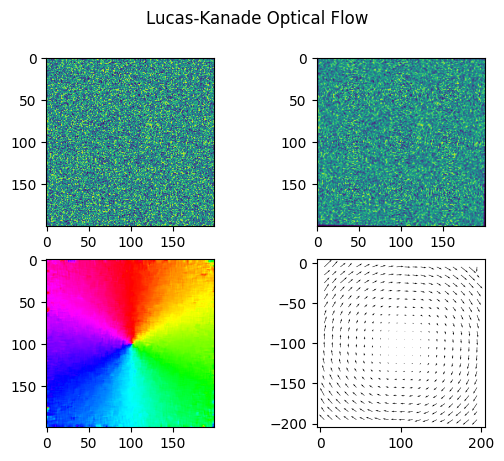

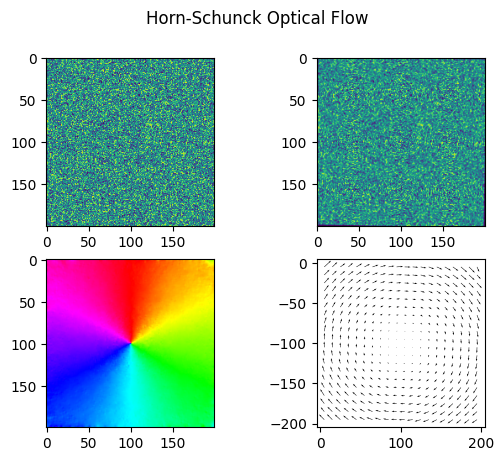

In [182]:
# Generate random images
im1 = np.random.rand(200, 200).astype(np.float32)
im2 = im1.copy()
im2 = rotate_image(im2, -1)

# Compute optical flow using Lucas-Kanade and Horn-Schunck methods
U_lk, V_lk = lucas_kanade(im1, im2, 6)
U_hs, V_hs = horn_schunck(im1, im2, 1000, 0.5)

# Plot the results
fig1, ((ax1_11, ax1_12), (ax1_21, ax1_22)) = plt.subplots(2, 2)
ax1_11.imshow(im1)
ax1_12.imshow(im2)
show_flow(U_lk, V_lk, ax1_21, type='angle')
show_flow(U_lk, V_lk, ax1_22, type='field', set_aspect=True)
fig1.suptitle('Lucas-Kanade Optical Flow')

fig2, ((ax_11, ax_12), (ax_21, ax_22)) = plt.subplots(2, 2)
ax_11.imshow(im1)
ax_12.imshow(im2)
show_flow(U_hs, V_hs, ax_21, type='angle')
show_flow(U_hs, V_hs, ax_22, type='field', set_aspect=True)
fig2.suptitle('Horn-Schunck Optical Flow')
plt.show()

Test both methods on other images (at least 3 more pairs of images), include
results in the report and comment them.  
You can use images included in the project
material or (even better) add your own examples.

In [157]:
def plot_image_pair(frame_1, frame_2):
  fig2, ((ax_11, ax_12), (ax_21, ax_22)) = plt.subplots(2, 2)
  ax_11.imshow(frame_1)
  ax_12.imshow(frame_2)
  U_lk, V_lk = lucas_kanade(frame_1, frame_2, 6)
  U_hs, V_hs = horn_schunck(frame_1, frame_2, 1000, 0.5)
  show_flow(U_hs, V_hs, ax_21, type='field', set_aspect=True)
  show_flow(U_lk, V_lk, ax_22, type='field', set_aspect=True)
  fig2.suptitle('optical flow')
  plt.show()

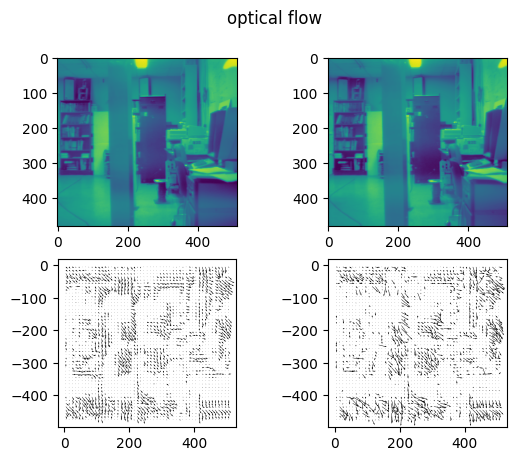

In [158]:
lab2 = read_folder_to_video("material/lab2/")
plot_image_pair(lab2[0], lab2[1])

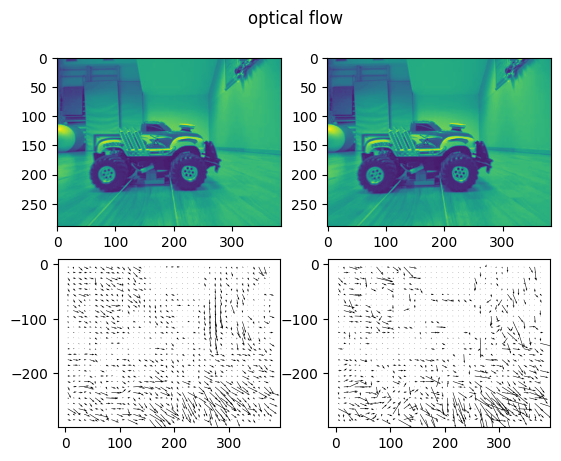

In [167]:
collision = read_folder_to_video("material/collision/")
plot_image_pair(collision[160], collision[161])

#### Q:
Measure time for Lucas-Kanade and Horn-Schunck optical flow methods and
report measurements.
- Can you speed-up Horn-Schunck method, e.g., by initializing
it with output of Lucas-Kanade?
- What is the speed and performance of the improved
Horn-Schunck?

In [194]:
# Compute optical flow using Lucas-Kanade and Horn-Schunck methods
import time

iters = 100
start_time = time.time_ns()
for i in range(iters):
  U_lk, V_lk = lucas_kanade(im1, im2, 6)
end_time = time.time_ns()
execution_time = end_time - start_time
print("lucas_kanade time: {:.2f} milliseconds".format(execution_time/(1000000 * iters)))

# U_hs, V_hs = horn_schunck(im1, im2, 1000, 0.5)

lucas_kanade time: 3.03 milliseconds


In [197]:
start_time = time.time_ns()
for i in range(iters):
  U_hs, V_hs = horn_schunck(im1, im2, 1000, 0.5)
end_time = time.time_ns()
execution_time = end_time - start_time
print("horn_schunck time: {:.2f} milliseconds".format(execution_time/(1000000 * iters)))

horn_schunck time: 38.44 milliseconds


In [199]:
start_time = time.time_ns()
for i in range(iters):
  U_hs, V_hs = horn_schunck(im1, im2, 1000, 0.5, start_uv=(U_lk, V_lk))
end_time = time.time_ns()
execution_time = end_time - start_time
print("horn_schunck initialized by LK uv's time: {:.2f} milliseconds".format(execution_time/(1000000 * iters)))

horn_schunck initialized by LK uv's time: 6.21 milliseconds


#### A:
- times averaged in 100 iterations:
  - lucas_kanade time: `3.03` milliseconds
    - horn_schunck time: `99.86` milliseconds
  - horn_schunck initialized by LK uv's time: `6.21` milliseconds
    - (time without running lucas_kanade)

#### Q:
How can we determine where the Lucas-Kanade optical flow can not be estimated reliably?  
Incorporate this idea into your function lucas-kanade and show the improvement on an example.  
Try not to compute the actual eigenvalues, but use **the Harris response instead**.

#### A:
Optical flow s dfficult to compute where the images look "flat". By calculating the `Harris response` over the image we find regions of interest. Harris detector will fire strongly where corners are detected and will return a low number (zero) where the image is flat.

In [150]:
def harris(frame_1: np.ndarray, frame_2: np.ndarray, N: int = 3) -> np.ndarray:
    """
    Compute the Harris response for optical flow reliability estimation.

    Parameters:
        frame_diff (np.ndarray): Difference between two frames (grayscale).
        N (int): Size of the window for spatial averaging. Default is 3.

    Returns:
        np.ndarray: Harris response map.
    """
    frame_diff = np.abs(frame_1 - frame_2)
    # Compute spatial derivatives
    I_x = np.gradient(frame_diff, axis=1)
    I_y = np.gradient(frame_diff, axis=0)

    # Compute structure tensor components
    I_x2 = I_x ** 2
    I_y2 = I_y ** 2
    I_xy = I_x * I_y

    # Smooth structure tensor components
    kernel = np.ones((N, N))
    I_x2 = np.convolve(I_x2.flatten(), kernel.flatten(), mode='same').reshape(frame_diff.shape)
    I_y2 = np.convolve(I_y2.flatten(), kernel.flatten(), mode='same').reshape(frame_diff.shape)
    I_xy = np.convolve(I_xy.flatten(), kernel.flatten(), mode='same').reshape(frame_diff.shape)

    # Compute Harris response
    k = 0.04 # Harris constant
    harris_response = I_x2 * I_y2 - I_xy ** 2 - k * (I_x2 + I_y2) ** 2
    harris_response = cv2.convertScaleAbs(harris_response, alpha=1.1)
    return harris_response

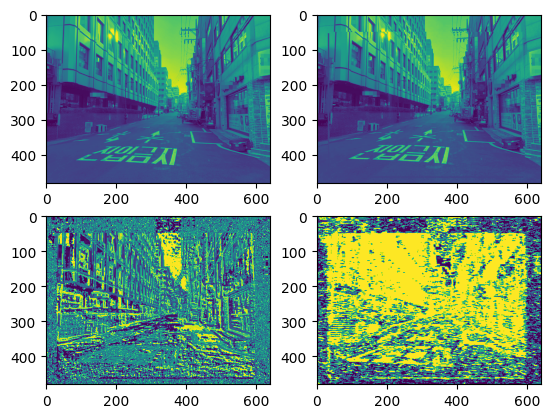

In [151]:
city1 = cv2.imread("material/city.jpg", cv2.IMREAD_GRAYSCALE)
city2 = cv2.imread("material/city2.jpg", cv2.IMREAD_GRAYSCALE)

fig2, ((ax_11, ax_12), (ax_21, ax_22)) = plt.subplots(2, 2)
ax_11.imshow(city1)
ax_12.imshow(city2)
ax_21.imshow(city1 - city2)

harr = harris(city1, city2)
ax_22.imshow(harr)

As seen here, the two image have ben created such, that a central rectangle has been move slightly.  
We can observer that the margin around the moved rectangle is noisy and mostly dark (bottom left). This means that the differences are small.  
When we apply harris detector we can see, that textured areas (windows on the buildings) fire a much stronger response than the bland texture of the road at the bottom.

In [84]:

def lucas_kanade_harris(frame_1: np.ndarray, frame_2: np.ndarray, N: int = 3) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute optical flow using Lucas-Kanade method with reliability estimation based on Harris response.

    Parameters:
        frame_1 (np.ndarray): First frame (grayscale).
        frame_2 (np.ndarray): Second frame (grayscale), shifted in time with respect to the first frame.
        N (int): Size of the window for spatial averaging. Default is 3.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple containing the horizontal (U) and vertical (V) components of the optical flow.
    """
    # Compute derivatives
    i_x, i_y, i_t = get_frame_derivatives(frame_1, frame_2)
    harris_response = harris(frame_1, frame_2)

    # Optical flow vectors
    i_x_i_t = cv2.filter2D(i_x * i_t, -1, np.ones((N, N)))
    i_y_i_t = cv2.filter2D(i_y * i_t, -1, np.ones((N, N)))
    i_x2 = cv2.filter2D(i_x * i_x, -1, np.ones((N, N)))
    i_y2 = cv2.filter2D(i_y * i_y, -1, np.ones((N, N)))
    i_x_i_y = cv2.filter2D(i_x * i_y, -1, np.ones((N, N)))

    # Compute denominator (avoid division by zero)
    denominator = (i_x2 * i_y2 - i_x_i_y * i_x_i_y)
    denominator[denominator == 0] = 1  # Avoid division by zero

    # Compute Lucas-Kanade optical flow
    U = (- i_y2 * i_x_i_t + i_x_i_y * i_y_i_t) / denominator
    V = (i_x_i_y * i_x_i_t - i_x2 * i_y_i_t) / denominator

    # Mask unreliable flow based on Harris response
    threshold = 0.01  # Adjust threshold as needed
    reliable_flow_mask = harris_response > threshold
    U[~reliable_flow_mask] = 0
    V[~reliable_flow_mask] = 0

    return U, V

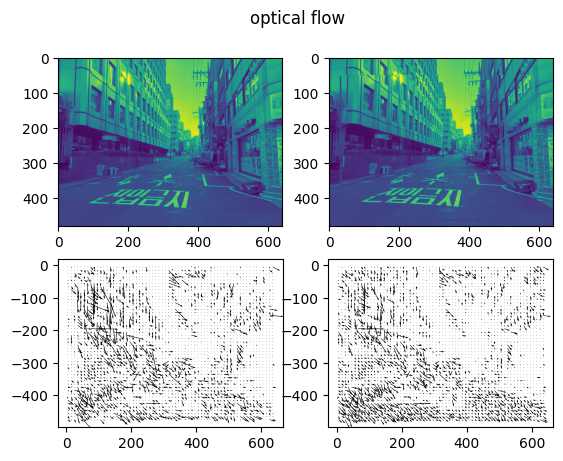

In [202]:

fig2, ((ax_11, ax_12), (ax_21, ax_22)) = plt.subplots(2, 2)
ax_11.imshow(city1)
ax_12.imshow(city2)
U_lkh, V_lkh = lucas_kanade_harris(city1, city2, 6)
U_lk, V_lk = lucas_kanade(city1, city2, 6)
show_flow(U_lkh, V_lkh, ax_21, type='field', set_aspect=True)
show_flow(U_lk, V_lk, ax_22, type='field', set_aspect=True)
fig2.suptitle('optical flow')
plt.show()

#### A:
Lucas kanade with harris respone does not create s many points in the "road" section